In [19]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

#alt.renderers.enable('notebook')

In [20]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from altair.vega import v5

In [21]:
import os 
file_folder = '../input/champs-scalar-coupling' if 'champs-scalar-coupling' in os.listdir('../data/input/') else '../data/input'
os.listdir(file_folder)

['scalar_coupling_contributions.csv',
 '.DS_Store',
 'mulliken_charges.csv',
 'structures.csv',
 'test.csv',
 '.gitkeep',
 'structures.zip',
 'train.csv',
 'magnetic_shielding_tensors.csv',
 'test.feather',
 'dipole_moments.csv',
 'train.feather',
 'sample_submission.csv',
 'potential_energy.csv']

In [54]:
import pandas as pd
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')

In [5]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001


In [36]:
len(np.unique(train["molecule_name"]))

85003

In [7]:
sub.head(20)

,id,scalar_coupling_constant
0,4658147,0
1,4658148,0
2,4658149,0
3,4658150,0
4,4658151,0
5,4658152,0
6,4658153,0
7,4658154,0
8,4658155,0
9,4658156,0


In [8]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942


In [13]:
pd.options.display.float_format = '{:.4g}'.format
train.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658e+06,4.658e+06,4.658e+06,4.658e+06
mean,2.329e+06,13.36,5.884,15.92
std,1.345e+06,3.268,4.994,34.94
min,0,0,0,-36.22
25%,1.165e+06,11,2,-0.255
50%,2.329e+06,13,5,2.281
75%,3.494e+06,16,8,7.391
max,4.658e+06,28,28,204.9


In [14]:
test.describe()

,id,atom_index_0,atom_index_1
count,2.506e+06,2.506e+06,2.506e+06
mean,5.911e+06,13.35,5.878
std,7.233e+05,3.272,4.992
min,4.658e+06,1,0
25%,5.285e+06,11,2
50%,5.911e+06,13,5
75%,6.537e+06,16,8
max,7.164e+06,28,28


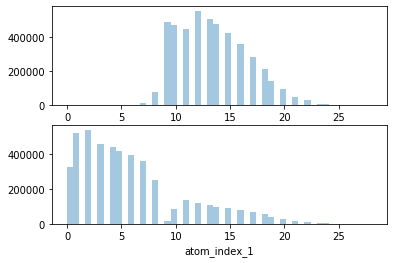

In [25]:
# Create an empty Figure
fig = plt.figure()

# Add an Axes to this fig
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.distplot(train["atom_index_0"],kde = False,ax = ax1)
ax2 = sns.distplot(train["atom_index_1"],kde = False,ax = ax2)

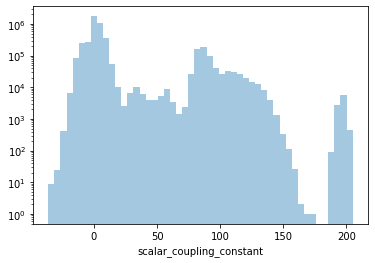

In [30]:
# Create an empty Figure
fig = plt.figure()

# Add an Axes to this fig
ax1 = fig.add_subplot()
ax1.set_yscale('log') 
ax1 = sns.distplot(train["scalar_coupling_constant"], kde = False , ax = ax1)

In [31]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

原子間距離を特徴量とする

In [33]:
atom_index_0_list = np.unique(train["atom_index_0"])

for atom_index in atom_index_0_list:
    atom_index_1 = train[[train["atom_index_0"] == atom_index]]["atom_index_1"]

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)


,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.662,0,1,C,0.5995,0,1
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.662,0,1,C,-0.5995,0,1
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.662,0,1,H,1.662,0,1
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.662,0,1,C,0.5995,0,1
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.662,0,1,C,-0.5995,0,1


In [61]:
molecule_name_array  = np.unique(structures["molecule_name"])

# df = train[train["atom_index_0"]==1]
# df.head()

molecule_dic = {}
#print(train[train["molecule_name"]=="dsgdb9nsd_000004"]["atom_index_0"])
#atom_size = [np.max(x) for x in molecule_name_array]

atom_size_list = []
molecule_name_list = []

for molecule_name in molecule_name_array:
    atom_size = np.amax(structures[structures["molecule_name"]==molecule_name]["atom_index"])
    atom_size_list.append(atom_size)
    molecule_name_list.append(molecule_name)

KeyboardInterrupt: 

In [64]:
molecule_size = pd.DataFrame({"molecule_name":molecule_name_list,
                             "atom_size":atom_size_list})

In [70]:
df = pd.merge(train,molecule_size,how = "left",
             left_on = ["molecule_name"],
             right_on = ["molecule_name"])

In [98]:
df2 = df.dropna()

def size(size):
    if size <= 7:
        return '1-7'
    elif 8 <= size <= 14:
        return "8-14"
    elif 15 <= size <= 21:
        return "15-21"
    elif 22 <= size <= 28:
        return "22-28"
    else:
        return "non"
        
# personという新しい列を追加します。
df2['size_type'] = df2["atom_size"].apply(size)

In [99]:
df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_size,size_type
0,0,dsgdb9nsd_000001,1,0,1JHC,84.81,4,1-7
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.26,4,1-7
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.25,4,1-7
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.25,4,1-7
4,4,dsgdb9nsd_000001,2,0,1JHC,84.81,4,1-7


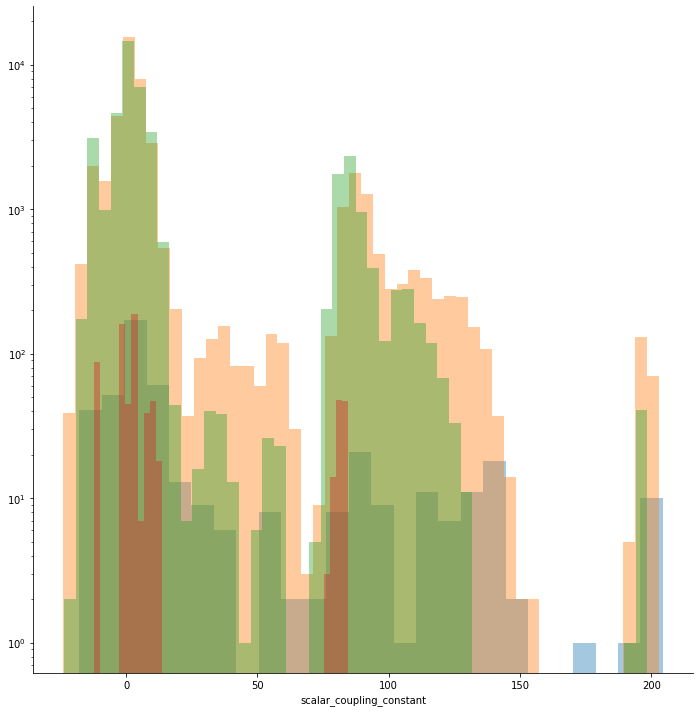

In [101]:




# Add an Axes to this fig
#ax1 = fig.add_subplot()
#ax1.set_yscale('log') 
#ax1 = sns.distplot(df2["scalar_coupling_constant"], kde = False , ax = ax1,hue = "atom_size")

ax1 = sns.FacetGrid(df2, hue='size_type',size=10)
ax1.map(sns.distplot, "scalar_coupling_constant", label='',kde =False).set(yscale = 'log')

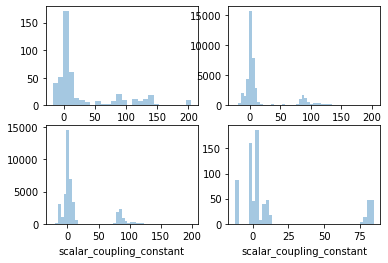

In [103]:
fig = plt.figure()

# Add an Axes to this fig
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1 = sns.distplot(df2[df2["size_type"]=="1-7"]["scalar_coupling_constant"],kde = False,ax = ax1)
ax2 = sns.distplot(df2[df2["size_type"]=="8-14"]["scalar_coupling_constant"],kde = False,ax = ax2)
ax3 = sns.distplot(df2[df2["size_type"]=="15-21"]["scalar_coupling_constant"],kde = False,ax = ax3)
ax4 = sns.distplot(df2[df2["size_type"]=="22-28"]["scalar_coupling_constant"],kde = False,ax = ax4)

In [104]:
df2["molecule_couples"] = df2.groupby("molecule_name")[""].transform("count")

In [105]:
df2.

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_size,size_type,molecule_couples
0,0,dsgdb9nsd_000001,1,0,1JHC,84.81,4,1-7,10
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.26,4,1-7,10
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.25,4,1-7,10
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.25,4,1-7,10
4,4,dsgdb9nsd_000001,2,0,1JHC,84.81,4,1-7,10
